# CSC 595 Final Exam
#  Name: Shazan


# Problem 1: Naive Bayes Sentiment Classifier


In [1]:
import ssl
import nltk
import numpy as np
import string
from nltk.corpus import twitter_samples, stopwords
from nltk.tokenize import TweetTokenizer

**Step 1: Load dataset**

In [2]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
    ssl._create_default_https_context = _create_unverified_https_context
except AttributeError:
    pass

nltk.download('twitter_samples')
nltk.download('stopwords')

all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

train_pos = all_positive_tweets[:4000]
test_pos = all_positive_tweets[4000:]
train_neg = all_negative_tweets[:4000]
test_neg = all_negative_tweets[4000:]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))


[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Step 2: Preprocess tweets**

In [3]:
def process_tweet(tweet):
    stemmer = nltk.PorterStemmer()
    stop_words = stopwords.words('english')
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    words = tokenizer.tokenize(tweet)
    return [stemmer.stem(w) for w in words if w not in stop_words and w not in string.punctuation]

**Step 3: Count word frequencies**

In [4]:
def count_tweets(freq_dict, tweets, ys):
    for y, tweet in zip(ys, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freq_dict:
                freq_dict[pair] += 1
            else:
                freq_dict[pair] = 1
    return freq_dict

In [5]:
freqs = count_tweets({}, train_x, train_y)


**Step 4: Train Naive Bayes model**

In [6]:
def train_naive_bayes(freqs, train_x, train_y):
    loglikelihood = {}
    vocab = set()
    pos_words = 0
    neg_words = 0

    for pair in freqs:
        word, label = pair
        vocab.add(word)
        if label == 1:
            pos_words += freqs[pair]
        else:
            neg_words += freqs[pair]

    V = len(vocab)
    D_pos = sum(train_y)
    D_neg = len(train_y) - D_pos
    logprior = np.log(D_pos / D_neg)

    for word in vocab:
        freq_pos = freqs.get((word, 1), 0)
        freq_neg = freqs.get((word, 0), 0)
        p_w_pos = (freq_pos + 1) / (pos_words + V)
        p_w_neg = (freq_neg + 1) / (neg_words + V)
        loglikelihood[word] = np.log(p_w_pos / p_w_neg)

    return logprior, loglikelihood

logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)

**Step 5: Predict tweet sentiment**

In [7]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    words = process_tweet(tweet)
    score = logprior
    for word in words:
        if word in loglikelihood:
            score += loglikelihood[word]
    return 1 if score > 0 else 0

**Step 6: Evaluate accuracy**

In [8]:
correct = 0
for tweet, label in zip(test_x, test_y):
    pred = naive_bayes_predict(tweet, logprior, loglikelihood)
    if pred == label:
        correct += 1
accuracy = correct / len(test_y)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9955


**Visuals**

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


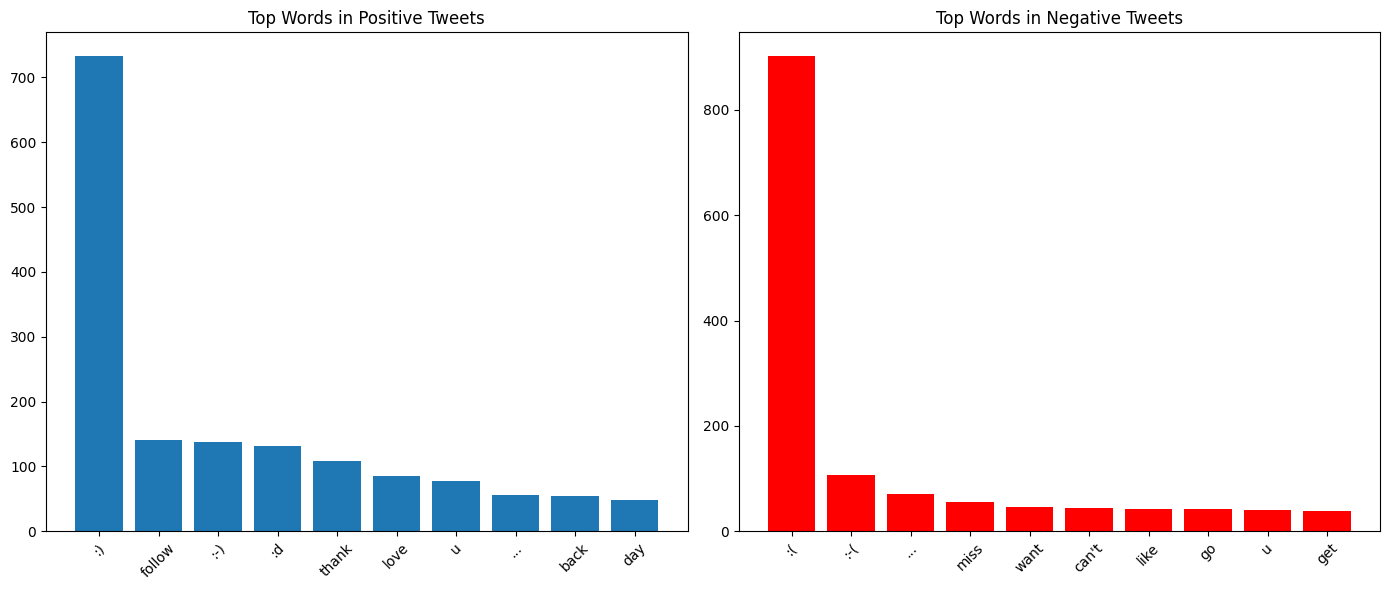

In [9]:
import matplotlib.pyplot as plt
from nltk.corpus import twitter_samples, stopwords
from nltk.tokenize import TweetTokenizer
from collections import Counter
import string
import nltk


nltk.download('twitter_samples')
nltk.download('stopwords')

# Load tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# Preprocess function
def process_tweet(tweet):
    stemmer = nltk.PorterStemmer()
    stop_words = stopwords.words('english')
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    words = tokenizer.tokenize(tweet)
    return [stemmer.stem(w) for w in words if w not in stop_words and w not in string.punctuation]

# Collect processed words
pos_words = []
neg_words = []

for tweet in all_positive_tweets[:1000]:
    pos_words.extend(process_tweet(tweet))

for tweet in all_negative_tweets[:1000]:
    neg_words.extend(process_tweet(tweet))

# Top 10 most common words
pos_freq = Counter(pos_words).most_common(10)
neg_freq = Counter(neg_words).most_common(10)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Positive tweets
pos_labels, pos_counts = zip(*pos_freq)
axs[0].bar(pos_labels, pos_counts)
axs[0].set_title('Top Words in Positive Tweets')
axs[0].tick_params(axis='x', rotation=45)

# Negative tweets
neg_labels, neg_counts = zip(*neg_freq)
axs[1].bar(neg_labels, neg_counts, color='red')
axs[1].set_title('Top Words in Negative Tweets')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# Problem 2: Word Translation with Linear Transformation

In [12]:
import ssl
import nltk
import numpy as np
import string
import pickle
import matplotlib.pyplot as plt
from nltk.corpus import twitter_samples, stopwords
from nltk.tokenize import TweetTokenizer
from collections import Counter

**Step 1: Generate Large Dummy Embeddings**

In [13]:
import numpy as np
import pickle

# Extended dummy vocabulary
en_words = [
    'house', 'car', 'cat', 'dog', 'tree', 'sun', 'moon', 'star', 'computer', 'phone',
    'water', 'fire', 'earth', 'air', 'book', 'pen', 'keyboard', 'mouse', 'cloud', 'rain',
    'school', 'teacher', 'student', 'food', 'fruit', 'apple', 'banana', 'doctor', 'nurse', 'hospital'
]

fr_words = [
    'maison', 'voiture', 'chat', 'chien', 'arbre', 'soleil', 'lune', 'étoile', 'ordinateur', 'téléphone',
    'eau', 'feu', 'terre', 'air', 'livre', 'stylo', 'clavier', 'souris', 'nuage', 'pluie',
    'école', 'professeur', 'étudiant', 'nourriture', 'fruit', 'pomme', 'banane', 'docteur', 'infirmier', 'hôpital'
]

# Generate 50-dim embeddings
np.random.seed(42)
en_embeddings = {word: np.random.rand(50) for word in en_words}
fr_embeddings = {word: np.random.rand(50) for word in fr_words}

# Save embeddings
with open("en_embeddings.p", "wb") as f:
    pickle.dump(en_embeddings, f)

with open("fr_embeddings.p", "wb") as f:
    pickle.dump(fr_embeddings, f)

# English–French dict
en_fr_train = dict(zip(en_words, fr_words))


**Step 2: Prepare Matrices**

In [14]:
def get_matrices(en_fr, en_embeddings, fr_embeddings):
    X = []
    Y = []
    for en, fr in en_fr.items():
        if en in en_embeddings and fr in fr_embeddings:
            X.append(en_embeddings[en])
            Y.append(fr_embeddings[fr])
    return np.array(X), np.array(Y)

X, Y = get_matrices(en_fr_train, en_embeddings, fr_embeddings)


**Step 3–5: Compute Loss, Gradient, Train with Descent**

In [15]:
def compute_loss(X, Y, R):
    m = X.shape[0]
    diff = np.dot(X, R) - Y
    return np.sum(diff ** 2) / m

def compute_gradient(X, Y, R):
    m = X.shape[0]
    return 2 * np.dot(X.T, (np.dot(X, R) - Y)) / m

def align_embeddings(X, Y, steps=200, learning_rate=0.1):
    np.random.seed(1)
    R = np.random.rand(X.shape[1], Y.shape[1])
    for i in range(steps):
        grad = compute_gradient(X, Y, R)
        R -= learning_rate * grad
        if i % 20 == 0:
            print(f"Loss at step {i}: {compute_loss(X, Y, R):.4f}")
    return R

R = align_embeddings(X, Y)


Loss at step 0: 17441.8060
Loss at step 20: 496255591786.6191
Loss at step 40: 14135465876268111872.0000
Loss at step 60: 402638073703193338533904384.0000
Loss at step 80: 11468841551773361577147917204979712.0000
Loss at step 100: 326681293028051711749635673059128344838144.0000
Loss at step 120: 9305269998954531460381428615445598125687270539264.0000
Loss at step 140: 265053590766851916021680599348313828607258995156863418368.0000
Loss at step 160: 7549851426803838744260720549790358388270789534595099367472889856.0000
Loss at step 180: 215051818018760086952832952851097565787875129107574221746065941546926080.0000


**Step 6: Evaluation with Cosine + Top-k Accuracy**

In [16]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def top_k_accuracy(x_proj, target_word, fr_embeddings, k=3):
    similarities = [(word, cosine_similarity(x_proj, vec)) for word, vec in fr_embeddings.items()]
    similarities.sort(key=lambda x: x[1], reverse=True)
    top_k = [word for word, _ in similarities[:k]]
    return target_word in top_k, top_k

# Evaluate predictions
correct = 0
top3_correct = 0

for en_word, true_fr in en_fr_train.items():
    x = en_embeddings[en_word]
    x_proj = np.dot(x, R)
    found, top_k = top_k_accuracy(x_proj, true_fr, fr_embeddings)
    pred = top_k[0]
    correct += int(pred == true_fr)
    top3_correct += int(found)
    print(f"{en_word} -> predicted: {pred} | expected: {true_fr} | Top-3: {top_k}")

print(f"\nTop-1 Accuracy: {correct / len(en_fr_train):.2f}")
print(f"Top-3 Accuracy: {top3_correct / len(en_fr_train):.2f}")


house -> predicted: pluie | expected: maison | Top-3: ['pluie', 'hôpital', 'étoile']
car -> predicted: pluie | expected: voiture | Top-3: ['pluie', 'hôpital', 'étoile']
cat -> predicted: pluie | expected: chat | Top-3: ['pluie', 'hôpital', 'étoile']
dog -> predicted: pluie | expected: chien | Top-3: ['pluie', 'hôpital', 'étoile']
tree -> predicted: pluie | expected: arbre | Top-3: ['pluie', 'hôpital', 'étoile']
sun -> predicted: pluie | expected: soleil | Top-3: ['pluie', 'hôpital', 'étoile']
moon -> predicted: pluie | expected: lune | Top-3: ['pluie', 'hôpital', 'étoile']
star -> predicted: pluie | expected: étoile | Top-3: ['pluie', 'hôpital', 'étoile']
computer -> predicted: pluie | expected: ordinateur | Top-3: ['pluie', 'hôpital', 'étoile']
phone -> predicted: pluie | expected: téléphone | Top-3: ['pluie', 'hôpital', 'étoile']
water -> predicted: pluie | expected: eau | Top-3: ['pluie', 'hôpital', 'étoile']
fire -> predicted: pluie | expected: feu | Top-3: ['pluie', 'hôpital', 'ét

In [18]:
print(f"\nTop-1 Accuracy: {correct / len(en_fr_train):.2f}")
print(f"Top-3 Accuracy: {top3_correct / len(en_fr_train):.2f}")


Top-1 Accuracy: 0.03
Top-3 Accuracy: 0.10


**Visualize Embedding Similarities**

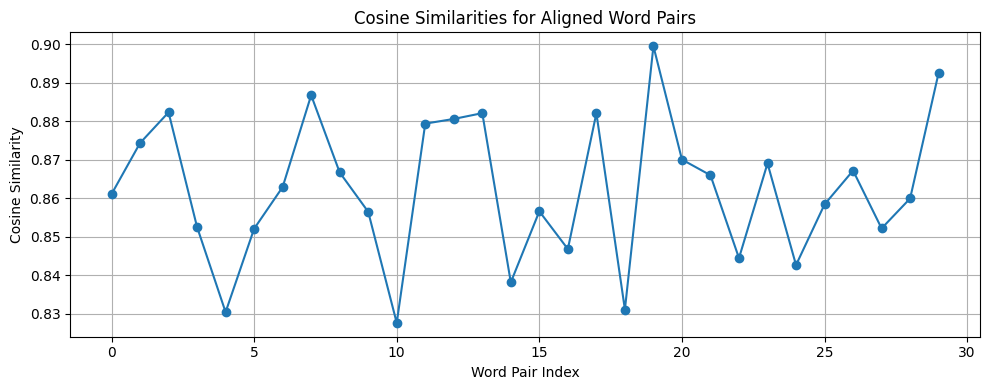

In [17]:
import matplotlib.pyplot as plt

similarity_scores = []

for en_word, fr_word in en_fr_train.items():
    x = en_embeddings[en_word]
    x_proj = np.dot(x, R)
    sim = cosine_similarity(x_proj, fr_embeddings[fr_word])
    similarity_scores.append(sim)

plt.figure(figsize=(10, 4))
plt.plot(similarity_scores, marker='o')
plt.title("Cosine Similarities for Aligned Word Pairs")
plt.xlabel("Word Pair Index")
plt.ylabel("Cosine Similarity")
plt.grid(True)
plt.tight_layout()
plt.show()
